## Importing Stuff

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix

## Viewing the dataset

Let's take a view into the dataset itself.

In [2]:
data = pd.read_csv("datasets/titanic_train.csv", index_col='PassengerId')
data_validate = pd.read_csv("datasets/titanic_test.csv", index_col='PassengerId')

In [3]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.Age.isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [67]:
data.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Cleaning and Wrangling the Data

We see that there are 891 entries in the dataset and 12 columns including the PassengerId as the index.

Of the 891 entries for Cabin 687 entries in total are null. This means that there isn't much we can do with the information about the cabin.

In addition, both the Ticket and Fare columns are more or less random. Furthermore, PassengerId is only a unique identifier and will not affect our model.

While it is possible to separate the Name into titles alone, I believe it is not needed.

So all of them are dropped.


We note that there 177 entries for Age do not exist. Instead of deleting these entries completely, we shall instead fill these age columns with the median age. We choose median over mean because there are both babies(Age is a fraction less than one) and very old people as well which might skew the value of mean.

### My Notes

First off, we really can't do anything with data_validate, because we don't have the labels (no 'Survived' column). I'm going to leave it alone and just do test/train splits, as usual.

I want to try three approaches:

(1) Filling in the missing age values with the median.

(2) Dropping the rows with missing age values.

(3) Use imputation to try and fill in the missing age values, given the other features in the data. After all, things like number of parents/children and number of siblings/spouses might correlate with age (e.g. passengers traveling alone are probably not children). 

To start, we need to convert categorical variables to numeric quantities. Let's do that for Sex and Embarked.

In [7]:
data.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
data.loc[:,'Sex']=data.Sex.map({'male':0,'female':1})

In [9]:
data.Sex.value_counts()

0    577
1    314
Name: Sex, dtype: int64

In [10]:
data.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

There's a couple missing values for Embarked. We'll use the most common value (S/0). 

In [11]:
data.loc[:,'Embarked']=data.Embarked.map({'S':0,'C':1,'Q':2})
data.loc[:,'Embarked']=data.Embarked.fillna(0)
data.loc[:,'Embarked']=data.Embarked.astype('int')

In [68]:
data.Embarked.value_counts(dropna=False)

0    646
1    168
2     77
Name: Embarked, dtype: int64

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null int64
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    891 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 83.5+ KB


Now let's create our two DFs: One where we fill in the missing Age's with the median, and the other where we drop rows with missing ages.

In [14]:
data_drop=data.dropna(subset=['Age']).copy()
data_fill=data.copy()

In [15]:
data.Age.median()

28.0

In [16]:
data_fill.loc[:,'Age']=data_fill.Age.fillna(data.Age.median())

### Bin Ages

Nearly all of the variables that we want to use for our features are discrete, categorical values that do not follow a Gaussian distribution. For these variables, the best Naive Bayes model we can use is the Multinomial Naive Bayes, MultinomialNB. The one exception is the Age variable. To accommodate for age, let's bin the age into buckets. I've chosen 4 buckets: 0-12, 12-24, 24-36, 36+. 

In [17]:
data_fill['Age_bins']=pd.cut(data_fill.Age,[0,12,24,36,100], labels=range(4)).astype('int')
data_drop['Age_bins']=pd.cut(data_drop.Age,[0,12,24,36,100], labels=range(4)).astype('int')

In [18]:
data_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    891 non-null int64
Age_bins    891 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 90.5+ KB


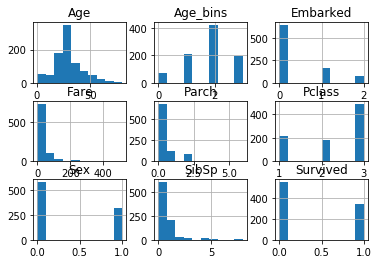

In [19]:
data_fill.hist();

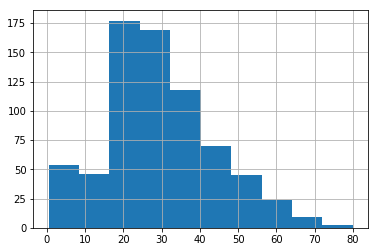

In [20]:
data_drop.Age.hist();

In [21]:
data_fill.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Age_bins'],
      dtype='object')

## Function Definitions

In [22]:
def print_metric(metric,scores):
    test_metric='test_'+metric
    train_metric='train_'+metric
    print("Mean test/train %s: %.3f \u00B1 %.4f / %.3f \u00B1 %.4f" % \
          (metric, scores[test_metric].mean(), scores[test_metric].std(), \
           scores[train_metric].mean(), scores[train_metric].std()))

In [23]:
def print_model_metrics(model,data,features,label,n_folds):
    metrics=['accuracy','precision_macro','recall_macro','f1_macro']
    scores = cross_validate(model, data[features], data[label], scoring=metrics, cv=n_folds, return_train_score=True)
    for metric in metrics:
        print_metric(metric,scores)

## Splitting up the data

We can now split the data into the labels and features.

In [24]:
features=['Pclass', 'Sex', 'Age_bins', 'SibSp', 'Parch','Embarked']
label='Survived'

## NAIVE BAYES MODEL

In [25]:
mnb=MultinomialNB()
print_model_metrics(mnb,data_fill,features,label,10)

Mean test/train accuracy: 0.789 ± 0.0303 / 0.793 ± 0.0050
Mean test/train precision_macro: 0.782 ± 0.0337 / 0.786 ± 0.0060
Mean test/train recall_macro: 0.766 ± 0.0347 / 0.770 ± 0.0049
Mean test/train f1_macro: 0.771 ± 0.0339 / 0.776 ± 0.0052


In [26]:
mnb=MultinomialNB()
print_model_metrics(mnb,data_drop,features,label,10)

Mean test/train accuracy: 0.777 ± 0.0420 / 0.783 ± 0.0068
Mean test/train precision_macro: 0.773 ± 0.0432 / 0.778 ± 0.0071
Mean test/train recall_macro: 0.763 ± 0.0482 / 0.769 ± 0.0074
Mean test/train f1_macro: 0.765 ± 0.0472 / 0.772 ± 0.0073


Overall, these are great initial results! We are getting ~80% precision/recall/accuracy for both the survived=0 and survived=1. Also, the train and test metrics are similar, indicating we haven't overfit the data. Finally, data_fill and data_drop give similar precision/recall (within standard deviation of the cross-validated models), but data_fill has slightly better overall accuracy.

The main hyperparameter for Naive Bayes is alpha, the smoothing parameter. Let's see if we get better results with different values of alpha. We'll use data_fill for now. 

In [27]:
for n in range(1,5):
    alpha_var=n*0.25
    print("RESULTS FOR MODEL WITH alpha=%.2f" % alpha_var)
    mnb=MultinomialNB(alpha=alpha_var)
    print_model_metrics(mnb,data_fill,features,label, 10)
    print('\n')

RESULTS FOR MODEL WITH alpha=0.25
Mean test/train accuracy: 0.789 ± 0.0303 / 0.793 ± 0.0048
Mean test/train precision_macro: 0.782 ± 0.0337 / 0.786 ± 0.0056
Mean test/train recall_macro: 0.766 ± 0.0347 / 0.771 ± 0.0049
Mean test/train f1_macro: 0.771 ± 0.0339 / 0.776 ± 0.0051


RESULTS FOR MODEL WITH alpha=0.50
Mean test/train accuracy: 0.789 ± 0.0303 / 0.793 ± 0.0048
Mean test/train precision_macro: 0.782 ± 0.0337 / 0.786 ± 0.0057
Mean test/train recall_macro: 0.766 ± 0.0347 / 0.771 ± 0.0048
Mean test/train f1_macro: 0.771 ± 0.0339 / 0.776 ± 0.0050


RESULTS FOR MODEL WITH alpha=0.75
Mean test/train accuracy: 0.789 ± 0.0303 / 0.793 ± 0.0050
Mean test/train precision_macro: 0.782 ± 0.0337 / 0.786 ± 0.0061
Mean test/train recall_macro: 0.766 ± 0.0347 / 0.771 ± 0.0048
Mean test/train f1_macro: 0.771 ± 0.0339 / 0.776 ± 0.0051


RESULTS FOR MODEL WITH alpha=1.00
Mean test/train accuracy: 0.789 ± 0.0303 / 0.793 ± 0.0050
Mean test/train precision_macro: 0.782 ± 0.0337 / 0.786 ± 0.0060
Mean t

Change alpha seems to have NO EFFECT on the results. I'm not sure what that means about the model, but it seems that there's no reason to choose a value of alpha other than the default value of 1. 

### IMPUTE MISSING AGE BINS.

In [28]:
features_age=['Pclass', 'Sex', 'SibSp', 'Parch','Embarked']
label_age='Age_bins'

In [29]:
mnb_age=MultinomialNB()
print_model_metrics(mnb_age,data_drop,features_age,label_age,10)

Mean test/train accuracy: 0.386 ± 0.0608 / 0.391 ± 0.0103
Mean test/train precision_macro: 0.326 ± 0.1243 / 0.338 ± 0.0463
Mean test/train recall_macro: 0.373 ± 0.0765 / 0.379 ± 0.0119
Mean test/train f1_macro: 0.316 ± 0.0829 / 0.327 ± 0.0176


/Users/mark.henle/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mark.henle/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mark.henle/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mark.henle/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Use

### Imputation Results

The precision/recall is not great, but it's probably better than a random guess of a median age, particularly given the relatively even distribution of ages in the bins we've created. Let's see if we get better results using these results to populate the missing ages

In [30]:
data_drop.Age_bins.value_counts(dropna=False)

2    242
1    208
3    195
0     69
Name: Age_bins, dtype: int64

In [31]:
mnb_age=MultinomialNB()
mnb_age.fit(data_drop[features_age],data_drop[label_age])

data_impute=data.copy()
data_impute['Age_bins']=pd.cut(data_impute.Age,[0,12,24,36,100], labels=range(4)).astype('int')
data_impute.loc[data_impute.Age.isnull(),'Age_bins']=\
mnb_age.predict(data_impute.loc[data_impute.Age.isnull(),features_age])

In [32]:
data_impute.Age_bins.value_counts(dropna=False,sort=False)

0     80
1    208
2    399
3    204
Name: Age_bins, dtype: int64

In [33]:
mnb_age=MultinomialNB()
print_model_metrics(mnb_age,data_impute,features,label,20)

Mean test/train accuracy: 0.786 ± 0.0425 / 0.792 ± 0.0041
Mean test/train precision_macro: 0.783 ± 0.0487 / 0.785 ± 0.0052
Mean test/train recall_macro: 0.763 ± 0.0492 / 0.769 ± 0.0036
Mean test/train f1_macro: 0.767 ± 0.0483 / 0.775 ± 0.0040


As a reminder, here are the metrics for the data where we fill in missing Ages with the median and where we drop those rows.

In [34]:
mnb=MultinomialNB()
print_model_metrics(mnb,data_fill,features,label,20)

Mean test/train accuracy: 0.789 ± 0.0418 / 0.793 ± 0.0034
Mean test/train precision_macro: 0.786 ± 0.0480 / 0.785 ± 0.0041
Mean test/train recall_macro: 0.765 ± 0.0485 / 0.770 ± 0.0034
Mean test/train f1_macro: 0.769 ± 0.0476 / 0.775 ± 0.0036


In [35]:
mnb=MultinomialNB()
print_model_metrics(mnb,data_drop,features,label,20)

Mean test/train accuracy: 0.774 ± 0.0605 / 0.783 ± 0.0037
Mean test/train precision_macro: 0.780 ± 0.0675 / 0.778 ± 0.0039
Mean test/train recall_macro: 0.760 ± 0.0615 / 0.769 ± 0.0041
Mean test/train f1_macro: 0.761 ± 0.0624 / 0.772 ± 0.0040


### Results: Survived Prediction with Age bin Impution

The data_impute metrics are essentially identical to the data_fill metrics. Both are better than the data_drop metrics. So unfortunately, it seems that a Naive Bayes model is not particularly effective in determining Age from the other features in the data.

## RANDOM FOREST MODEL

Let's see if we get better results from a Random Forest model. I've done some hyper-parameter tuning and found that limiting the max depth was an effective way to prevent overfitting and thus get better test metrics. I also found that the default options of bootstrapping and limiting the number of features when looking for the best split gave slightly worse results than not doing either of those things.

In [36]:
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=8)
print_model_metrics(rf,data_fill,features,label,20)

Mean test/train accuracy: 0.824 ± 0.0543 / 0.859 ± 0.0035
Mean test/train precision_macro: 0.828 ± 0.0590 / 0.867 ± 0.0048
Mean test/train recall_macro: 0.797 ± 0.0644 / 0.833 ± 0.0048
Mean test/train f1_macro: 0.804 ± 0.0633 / 0.844 ± 0.0042


In [37]:
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=4)
print_model_metrics(rf,data_fill,features,label,20)

Mean test/train accuracy: 0.824 ± 0.0466 / 0.838 ± 0.0049
Mean test/train precision_macro: 0.833 ± 0.0524 / 0.846 ± 0.0085
Mean test/train recall_macro: 0.794 ± 0.0563 / 0.810 ± 0.0077
Mean test/train f1_macro: 0.803 ± 0.0555 / 0.821 ± 0.0062


In [38]:
# This gives the best results.
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=4,max_features=None,bootstrap=False)
print_model_metrics(rf,data_fill,features,label,20)

Mean test/train accuracy: 0.835 ± 0.0475 / 0.836 ± 0.0026
Mean test/train precision_macro: 0.856 ± 0.0500 / 0.856 ± 0.0028
Mean test/train recall_macro: 0.799 ± 0.0581 / 0.799 ± 0.0031
Mean test/train f1_macro: 0.811 ± 0.0582 / 0.814 ± 0.0032


This is a marginal improvement over the Naive Bayes metrics; the f1 score is 0.81 vs. 0.77 for the Naive Bayes model (both using the data_fill dataset). I've tried different random states for the RF model and the results are similar. 

Also note how the best RF model gives nearly identical metrics for the test and train dataset, indicating it is "well fit" (not overfit or underfit). Excellent!

What if we used Age instead of the bins? We can do that for the RF model because all variables don't need to be multinomial (like with Multinomial Naive Bayes).

In [40]:
features_rf=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Embarked']
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=4,max_features=None,bootstrap=False)
print_model_metrics(rf,data_fill,features_rf,label,20)

Mean test/train accuracy: 0.829 ± 0.0491 / 0.837 ± 0.0030
Mean test/train precision_macro: 0.853 ± 0.0511 / 0.861 ± 0.0025
Mean test/train recall_macro: 0.791 ± 0.0604 / 0.799 ± 0.0040
Mean test/train f1_macro: 0.804 ± 0.0607 / 0.814 ± 0.0039


This didn't seem to help much; if anything it hurt! So our best model so far is to use the Random Forest with Age_bins as the feature.

### Feature Engineering

I've tried a few variations on the features, and found that I could get better results from the Random Forest model if I dropped the "Embarked" feature and combined the "SibSp" and "Parch" features into one "family" feature (representing the total number of family members: siblings, spouses, parents, and children). 

In [41]:
data_fill['family']=data_fill['SibSp']+data_fill['Parch']

In [42]:
features_rf=['Pclass','Sex', 'Age_bins','family']
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=5)
print_model_metrics(rf,data_fill,features_rf,label,20)

Mean test/train accuracy: 0.835 ± 0.0546 / 0.839 ± 0.0028
Mean test/train precision_macro: 0.836 ± 0.0562 / 0.837 ± 0.0028
Mean test/train recall_macro: 0.815 ± 0.0652 / 0.818 ± 0.0034
Mean test/train f1_macro: 0.820 ± 0.0619 / 0.825 ± 0.0032


In [43]:
features_rf=['Pclass','Sex', 'Age_bins','family']
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=5,max_features=None,bootstrap=False)
print_model_metrics(rf,data_fill,features_rf,label,20)

Mean test/train accuracy: 0.834 ± 0.0544 / 0.840 ± 0.0028
Mean test/train precision_macro: 0.835 ± 0.0560 / 0.838 ± 0.0028
Mean test/train recall_macro: 0.813 ± 0.0639 / 0.818 ± 0.0034
Mean test/train f1_macro: 0.818 ± 0.0612 / 0.826 ± 0.0032


### Impute Age_bins

As above, let's try imputing the Age_bins (I also tried imputing the actual age using a RandomForestRegressor; the results were similar and thus not shown for brevity). 

In [44]:
features_rf_age=['Pclass','Sex','family']

data_drop['family']=data_drop['SibSp']+data_drop['Parch']

rf_age=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=4,max_features=None,bootstrap=False)
rf_age.fit(data_drop[features_rf_age],data_drop[label_age])

print_model_metrics(rf_age,data_drop,features_rf_age,label_age,10)

data_impute_rf=data.copy()
data_impute_rf['Age_bins']=pd.cut(data_impute_rf.Age,[0,12,24,36,100], labels=range(4)).astype('int')
data_impute_rf['family']=data_impute_rf['SibSp']+data_impute_rf['Parch']

data_impute_rf.loc[data_impute_rf.Age.isnull(),'Age_bins']=\
rf_age.predict(data_impute_rf.loc[data_impute_rf.Age.isnull(),features_rf_age])

Mean test/train accuracy: 0.460 ± 0.0624 / 0.477 ± 0.0071
Mean test/train precision_macro: 0.487 ± 0.0703 / 0.507 ± 0.0094
Mean test/train recall_macro: 0.499 ± 0.0781 / 0.522 ± 0.0257
Mean test/train f1_macro: 0.444 ± 0.0672 / 0.468 ± 0.0078


That's much better than the resuls we got from our Naive Bayes imputation. 

In [45]:
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=4,max_features=None,bootstrap=False)
print_model_metrics(rf,data_impute_rf,features_rf,label,20)

Mean test/train accuracy: 0.823 ± 0.0519 / 0.843 ± 0.0031
Mean test/train precision_macro: 0.821 ± 0.0537 / 0.836 ± 0.0044
Mean test/train recall_macro: 0.808 ± 0.0641 / 0.831 ± 0.0046
Mean test/train f1_macro: 0.808 ± 0.0597 / 0.833 ± 0.0033


Surprisingly, these results are actually  worse than the model using data_fill! Still, it's within the error range. But it indicates that imputing the Age bins didn't improve our results much as compared to using the median age. 

## SVM MODEL

Let's try an SVM model. I did a little hyperparameter tuning and came up with this model. 

For simplicity, I'm using data_fill here, i.e. I'm not going to try and impute the missing ages.

In [47]:
svm=make_pipeline(StandardScaler(), SVC(gamma=0.1,probability=True))
print_model_metrics(svm,data_fill,features,label,20)

Mean test/train accuracy: 0.827 ± 0.0501 / 0.838 ± 0.0035
Mean test/train precision_macro: 0.829 ± 0.0536 / 0.837 ± 0.0046
Mean test/train recall_macro: 0.805 ± 0.0582 / 0.815 ± 0.0037
Mean test/train f1_macro: 0.811 ± 0.0566 / 0.823 ± 0.0037


Not bad! The metrics are better than Naive Bayes and comparable to the Random Forest.

## VOTING CLASSIFIER: COMBINING ALL 3 MODELS INTO ONE

So we have 3 models that all give good results. Can we get better results if we use all 3 models at once? We can do that using a VotingClassifier, where each model "votes" on the outcome, and then the results are combined in some way to get an overall prediction. I found that a "soft" voting works best, where each model returns a probability of a person surviving. Using the weights supplied, the probabilities are combined to get an overall probability. Because the Random Forest model was the best and the Naive Bayes model was the worst, I weighted the RF model the most and the NB model the least.

In [53]:
# I had to suppress these annoying warnings; from a quick Google search the errors are not important.
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [54]:
# Here's the results if we use the original features.
svm=make_pipeline(StandardScaler(), SVC(gamma=0.1,probability=True))
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=4,max_features=None,bootstrap=False)
mnb=MultinomialNB()

vc = VotingClassifier(estimators=[('rf', rf),('svm', svm),('mnb',mnb)], voting='soft',weights=[0.5,0.3,0.2])

print('Naive Bayes')
print_model_metrics(mnb,data_fill,features,label,20)
print('\nRandom Forest')
print_model_metrics(rf,data_fill,features,label,20)
print('\nSVM')
print_model_metrics(svm,data_fill,features,label,20)
print('\nVotingClassifier')
print_model_metrics(vc,data_fill,features,label,20)

Naive Bayes
Mean test/train accuracy: 0.789 ± 0.0418 / 0.793 ± 0.0034
Mean test/train precision_macro: 0.786 ± 0.0480 / 0.785 ± 0.0041
Mean test/train recall_macro: 0.765 ± 0.0485 / 0.770 ± 0.0034
Mean test/train f1_macro: 0.769 ± 0.0476 / 0.775 ± 0.0036

Random Forest
Mean test/train accuracy: 0.835 ± 0.0475 / 0.836 ± 0.0026
Mean test/train precision_macro: 0.856 ± 0.0500 / 0.856 ± 0.0028
Mean test/train recall_macro: 0.799 ± 0.0581 / 0.799 ± 0.0031
Mean test/train f1_macro: 0.811 ± 0.0582 / 0.814 ± 0.0032

SVM
Mean test/train accuracy: 0.827 ± 0.0501 / 0.838 ± 0.0035
Mean test/train precision_macro: 0.829 ± 0.0536 / 0.837 ± 0.0046
Mean test/train recall_macro: 0.805 ± 0.0582 / 0.815 ± 0.0037
Mean test/train f1_macro: 0.811 ± 0.0566 / 0.823 ± 0.0037

VotingClassifier
Mean test/train accuracy: 0.829 ± 0.0474 / 0.840 ± 0.0032
Mean test/train precision_macro: 0.834 ± 0.0522 / 0.843 ± 0.0050
Mean test/train recall_macro: 0.805 ± 0.0562 / 0.815 ± 0.0033
Mean test/train f1_macro: 0.812 ± 0.

In [55]:
# And here's what happens if we use the "engineered" features for the RF model.
# Note that the other models are essentially unchanged by this result (slightly worse).
svm=make_pipeline(StandardScaler(), SVC(gamma=0.1,probability=True))
rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=5,max_features=None,bootstrap=False)
mnb=MultinomialNB()

vc = VotingClassifier(estimators=[('rf', rf),('svm', svm),('mnb',mnb)], voting='soft',weights=[0.5,0.3,0.2])

print('Naive Bayes')
print_model_metrics(mnb,data_fill,features_rf,label,20)
print('\nRandom Forest')
print_model_metrics(rf,data_fill,features_rf,label,20)
print('\nSVM')
print_model_metrics(svm,data_fill,features_rf,label,20)
print('\nVotingClassifier')
print_model_metrics(vc,data_fill,features_rf,label,20)

Naive Bayes
Mean test/train accuracy: 0.786 ± 0.0408 / 0.787 ± 0.0022
Mean test/train precision_macro: 0.780 ± 0.0445 / 0.777 ± 0.0023
Mean test/train recall_macro: 0.767 ± 0.0479 / 0.767 ± 0.0025
Mean test/train f1_macro: 0.769 ± 0.0467 / 0.771 ± 0.0024

Random Forest
Mean test/train accuracy: 0.834 ± 0.0544 / 0.840 ± 0.0028
Mean test/train precision_macro: 0.835 ± 0.0560 / 0.838 ± 0.0028
Mean test/train recall_macro: 0.813 ± 0.0639 / 0.818 ± 0.0034
Mean test/train f1_macro: 0.818 ± 0.0612 / 0.826 ± 0.0032

SVM
Mean test/train accuracy: 0.825 ± 0.0479 / 0.826 ± 0.0043
Mean test/train precision_macro: 0.827 ± 0.0513 / 0.822 ± 0.0044
Mean test/train recall_macro: 0.804 ± 0.0562 / 0.806 ± 0.0053
Mean test/train f1_macro: 0.809 ± 0.0535 / 0.812 ± 0.0050

VotingClassifier
Mean test/train accuracy: 0.833 ± 0.0558 / 0.839 ± 0.0029
Mean test/train precision_macro: 0.834 ± 0.0578 / 0.838 ± 0.0029
Mean test/train recall_macro: 0.813 ± 0.0655 / 0.819 ± 0.0035
Mean test/train f1_macro: 0.817 ± 0.

The VotingClassifier is essentially the same as the Random Forest model. So it seems that there is a strong overlap in the bad predictions of the models, i.e. there are certain passengers that none of the models are getting right. 

## OVERALL MODEL CONCLUSIONS

From all the results above, the RandomForest model with the engineered features seems to be the best overall model. Let's take a look at some other metrics for that model: Precision-Recall curve, ROC curve, and confusion matrix.

### PRECISION-RECALL, ROC, CONFUSION MATRIX

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data_fill[features_rf], data_fill[label],stratify=data_fill[label])

rf=RandomForestClassifier(random_state=1212, n_jobs=-1, max_depth=5,max_features=None,bootstrap=False)
rf.fit(X_train,y_train)
y_score=rf.predict_proba(X_test)
y_pred=rf.predict(X_test)

Note that using a stratified test/train split preserves the 0/1 distribution of the label. That's what we've been doing implicitly with the cross_validate models above.

In [57]:
y_test.value_counts(normalize=True)

0    0.61435
1    0.38565
Name: Survived, dtype: float64

In [58]:
y_train.value_counts(normalize=True)

0    0.616766
1    0.383234
Name: Survived, dtype: float64

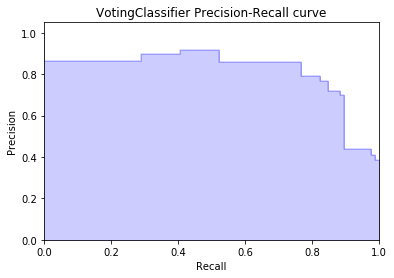

In [59]:
precision, recall, _ = precision_recall_curve(y_test, y_score[:,1])
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('VotingClassifier Precision-Recall curve')
plt.show()

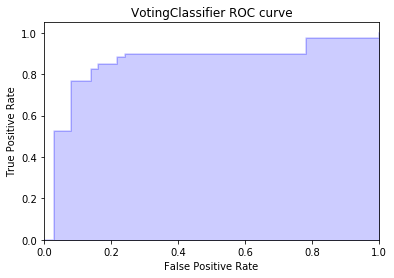

In [60]:

fpr,tpr, _ = roc_curve(y_test, y_score[:,1])
plt.step(fpr, tpr, color='b', alpha=0.2,
         where='post')
plt.fill_between(fpr, tpr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('VotingClassifier ROC curve')
plt.show()

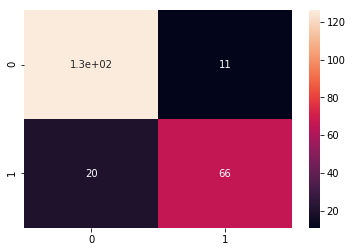

In [61]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True);

## OVERALL CONCLUSIONS

All 3 models -- Naive Bayes, Random Forest, and SVM -- give ~80% accuracy/precision/recall, which is very good. Neither the Naive Bayes model nor the Random Forest model were able to impute missing Age values very effectively; using the median age for these points was just as good. Also, constructing a VotingClassifier from all 3 models did not improve the results significantly. 